### 예제
1. csv 폴더에서 test_csv 폴더의 '오프라인.csv' 파일을 로드 
2. 컬럼의 이름을 변경 -> [기준년월, '업종', 성별, 연령대, 총이용건수, 총이용금액]
3. 결측치가 존재하는가?
    - 결측치의 대한 체크
    - 성별 컬럼에서 '-' 데이터가 존재하는가?
4. 기준년월 컬럼의 데이터 타입을 시계열 변경 
5. 성별을 기준으로 연도별 건당 이용금액의 평균이 어떻게 되는가?
    - 기준년 컬럼을 생성하여 기준년월에서 년도만 추출하여 대입
    - 건당이용금액 컬럼을 생성하여 총이용금액 / 총이용건수 의 결과를 대입
    - 기준년과 성별을 기준으로 그룹화를 하고 그룹화 연산으로는 건당이용금액의 평균을 구한다. 

In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
# 파일을 로드 
offline = pd.read_csv('../../csv/test_csv/오프라인.csv', 
    encoding='cp949')

In [ ]:
offline.head()

In [ ]:
# 컬럼의 이름을 변경
# case1 : rename() -> 특정 컬럼이나 인덱스를 변경할때 사용
# columns 변수를 변경하는것과의 차이점은 rename() 변경하기 전 확인이 가능
offline.rename(
    columns = {
        'crym' : '기준년월', 
        'tco_btc_nm' : '업종', 
        'ma_fem_dc' : '성별', 
        'agegrp_dc' : '연령대', 
        'tco_btc_u_ct' : '총이용건수', 
        'tco_btc_u_am' : '총이용금액'
    }
)

In [ ]:
# case2 : DataFrame안에 존재하는 columns 변수에 데이터를 변경 
offline.columns = ['기준년월', '업종', '성별', '연령대', 
                    '총이용건수', '총이용금액']

In [ ]:
offline.head()

In [ ]:
# 결측치의 개수를 확인 -> 결측치인가? -> 합
offline.isna().sum()

In [ ]:
offline.info()

In [ ]:
offline.describe()

In [ ]:
# 항목정의서에서 확인했을때 성별 컬럼의 결측치는 -
# - 의 개수도 확인 
(offline['성별'] == '-').sum()

In [ ]:
offline['성별'].isin(['-', '9']).sum()

In [ ]:
pd.to_datetime(offline['기준년월'] , format='%Y%m')

In [ ]:
# datetime 라이브러리 안에 존재하는 시계열로 변환하는 함수 
datetime.strptime(str(offline['기준년월'][0]), '%Y%m')

In [ ]:
offline['기준년월'] = offline['기준년월'].map(
    lambda x : datetime.strptime( str(x), '%Y%m' )
)

In [ ]:
# 기준년 컬럼을 생성하여 기준년월에서 년도만 추출하여 대입 
# case1 : map 함수를 이용
offline['기준년월'].map(
    lambda x : x.strftime('%Y')
)

In [ ]:
# case2 : Series에서 datetime 내장함수를 이용
offline['기준년월'].dt.strftime('%Y')

In [ ]:
# case3 : Series에서 dateitme 변수를 이용
offline['기준년'] = offline['기준년월'].dt.year

In [ ]:
# 건당이용금액 컬럼을 생성하여 총이용금액 / 총이용건수의 값을 대입 
offline['건당이용금액'] = \
     offline['총이용금액'] / offline['총이용건수']

In [ ]:
# 기준년, 성별을 기준으로 그룹화 -> 건당 이용금액의 평균
offline.groupby(['기준년', '성별'])[['건당이용금액']].mean()

In [ ]:
# 데이터프레임 데이터의 구조를 재 구조화 한다. 
# pivot_table() -> pandas 안에 존재, DataFrame 안에 존재 
pd.pivot_table(
    offline, 
    index = ['기준년', '성별'], 
    values = '건당이용금액', 
    aggfunc = 'mean'
)

In [ ]:
offline.pivot_table(
    index = ['기준년', '성별'], 
    values = '총이용건수', 
    aggfunc = 'sum'
)

In [ ]:
# 기준년월, 업종별 총 이용금액의 합계를 확인
group_data = \
     offline.groupby([ '기준년월', '업종' ])[['총이용금액']].sum()

In [60]:
import matplotlib.pyplot as plt
import platform

In [63]:
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='Malgun Gothic')

In [71]:
group_data = group_data.unstack()

In [72]:
group_data.columns

MultiIndex([('총이용금액',  '백화점'),
            ('총이용금액', '슈퍼마켓'),
            ('총이용금액',  '편의점'),
            ('총이용금액',  '할인점')],
           names=[None, '업종'])

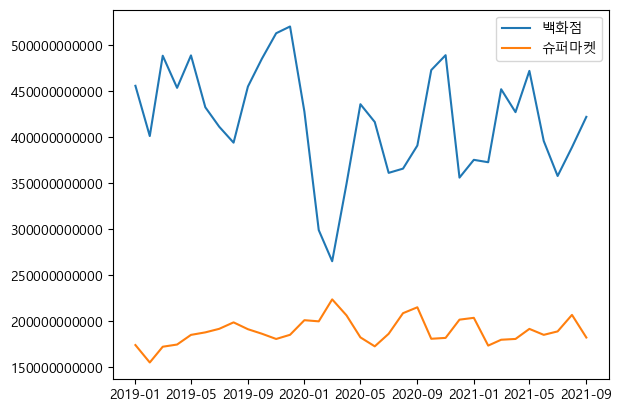

In [73]:
# 그래프에서 지수표현식을 제거 
plt.ticklabel_format(axis='y', style='plain', useMathText=True)
x = group_data.index
y1 = group_data[('총이용금액',  '백화점')]
y2 = group_data[('총이용금액',  '슈퍼마켓')]

plt.plot(x, y1, label='백화점')
plt.plot(x, y2, label='슈퍼마켓')
plt.legend()
plt.show()
# group_data.unstack().plot()